In [1]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import DynamicSystemAnalyzer
from src.PerformanceAnalyzer import PerformanceAnalyzer
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA

In [2]:
disp = True
activation = "tanh"
taskname = "MemoryAntiNumber"
train_config_file = f"train_config_{taskname}_{activation}.json"
config_dict = json.load(open(os.path.join(get_project_root(), "data", "configs", train_config_file), mode="r"))

In [3]:
# defining RNN:
N = config_dict["N"]
activation_name = config_dict["activation"]
if activation_name == 'relu':
    activation = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation = torch.tanh
elif activation_name == 'sigmoid':
    activation = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation = lambda x: torch.log(1 + torch.exp(5 * x))

dt = config_dict["dt"]
tau = config_dict["tau"]
constrained = config_dict["constrained"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
seed = config_dict["seed"]
rng = torch.Generator()
if not seed is None:
    rng.manual_seed(seed)
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

In [4]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

In [5]:
# Trainer:
lambda_orth = config_dict["lambda_orth"]
lambda_r = config_dict["lambda_r"]
mask = np.array(config_dict["mask"])
max_iter = config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [6]:
# General:
tag = config_dict["tag"]
timestr = time.strftime("%Y%m%d-%H%M%S")
data_folder = os.path.join(config_dict["data_folder"], timestr)

In [7]:
# # creating instances:
rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation, constrained=constrained,
                      sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      random_generator=rng)
task = eval("Task" + taskname)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

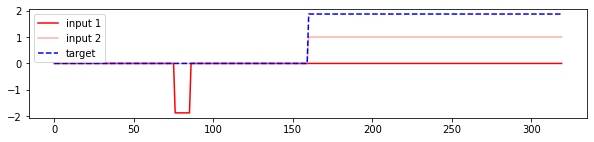

In [8]:
inputs, targets, conditions = task.get_batch()
ind = 11

fig = plt.figure(figsize = (10, 2))
plt.plot(inputs[0, :, ind], color = 'red', label = 'input 1')
plt.plot(inputs[1, :, ind], color = 'tomato', alpha = 0.5, label = 'input 2')
plt.plot(targets[0, :, ind], color = 'blue', linestyle = '--', label = 'target')
plt.legend()
plt.show()

In [9]:
rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask, same_batch=same_batch)

iteration 0, train loss: 1.550812, validation loss: 1.448594
iteration 1, train loss: 1.45006, validation loss: 1.405636
iteration 2, train loss: 1.407104, validation loss: 1.407742
iteration 3, train loss: 1.409713, validation loss: 1.385058
iteration 4, train loss: 1.387198, validation loss: 1.367049
iteration 5, train loss: 1.368605, validation loss: 1.347924
iteration 6, train loss: 1.349479, validation loss: 1.286571
iteration 7, train loss: 1.292582, validation loss: 1.140357
iteration 8, train loss: 1.187775, validation loss: 1.040278
iteration 9, train loss: 1.143733, validation loss: 1.031551
iteration 10, train loss: 1.073298, validation loss: 1.043596
iteration 11, train loss: 1.072658, validation loss: 0.911943
iteration 12, train loss: 1.03348, validation loss: 0.888896
iteration 13, train loss: 0.940616, validation loss: 0.864506
iteration 14, train loss: 0.913005, validation loss: 0.797225
iteration 15, train loss: 0.852228, validation loss: 0.78819
iteration 16, train l

iteration 117, train loss: 0.13325, validation loss: 0.112012
iteration 118, train loss: 0.125709, validation loss: 0.117535
iteration 119, train loss: 0.128239, validation loss: 0.11002
iteration 120, train loss: 0.123851, validation loss: 0.119442
iteration 121, train loss: 0.132074, validation loss: 0.108629
iteration 122, train loss: 0.12087, validation loss: 0.109524
iteration 123, train loss: 0.122603, validation loss: 0.115455
iteration 124, train loss: 0.127717, validation loss: 0.107553
iteration 125, train loss: 0.119553, validation loss: 0.116666
iteration 126, train loss: 0.131191, validation loss: 0.118306
iteration 127, train loss: 0.137237, validation loss: 0.102407
iteration 128, train loss: 0.11501, validation loss: 0.114879
iteration 129, train loss: 0.128697, validation loss: 0.115377
iteration 130, train loss: 0.127973, validation loss: 0.109304
iteration 131, train loss: 0.120973, validation loss: 0.10972
iteration 132, train loss: 0.122202, validation loss: 0.1075

iteration 244, train loss: 0.09838, validation loss: 0.089361
iteration 245, train loss: 0.102514, validation loss: 0.094341
iteration 246, train loss: 0.105333, validation loss: 0.088849
iteration 247, train loss: 0.102687, validation loss: 0.091058
iteration 248, train loss: 0.103807, validation loss: 0.090756
iteration 249, train loss: 0.102845, validation loss: 0.097084
iteration 250, train loss: 0.108147, validation loss: 0.095538
iteration 251, train loss: 0.109227, validation loss: 0.087982
iteration 252, train loss: 0.099444, validation loss: 0.081873
iteration 253, train loss: 0.093161, validation loss: 0.084974
iteration 254, train loss: 0.09712, validation loss: 0.089398
iteration 255, train loss: 0.098226, validation loss: 0.082048
iteration 256, train loss: 0.093511, validation loss: 0.082226
iteration 257, train loss: 0.096332, validation loss: 0.084733
iteration 258, train loss: 0.096097, validation loss: 0.081991
iteration 259, train loss: 0.096243, validation loss: 0.0

iteration 366, train loss: 0.040487, validation loss: 0.033438
iteration 367, train loss: 0.042472, validation loss: 0.029356
iteration 368, train loss: 0.041368, validation loss: 0.0271
iteration 369, train loss: 0.038301, validation loss: 0.028397
iteration 370, train loss: 0.038414, validation loss: 0.027403
iteration 371, train loss: 0.039082, validation loss: 0.025079
iteration 372, train loss: 0.035273, validation loss: 0.026535
iteration 373, train loss: 0.037298, validation loss: 0.025205
iteration 374, train loss: 0.036327, validation loss: 0.025926
iteration 375, train loss: 0.037699, validation loss: 0.024843
iteration 376, train loss: 0.036544, validation loss: 0.030127
iteration 377, train loss: 0.045881, validation loss: 0.063801
iteration 378, train loss: 0.071508, validation loss: 0.039681
iteration 379, train loss: 0.053866, validation loss: 0.025489
iteration 380, train loss: 0.036813, validation loss: 0.028284
iteration 381, train loss: 0.040144, validation loss: 0.0

iteration 492, train loss: 0.030362, validation loss: 0.017931
iteration 493, train loss: 0.030194, validation loss: 0.019861
iteration 494, train loss: 0.030567, validation loss: 0.016798
iteration 495, train loss: 0.027911, validation loss: 0.016693
iteration 496, train loss: 0.027586, validation loss: 0.019164
iteration 497, train loss: 0.028673, validation loss: 0.018542
iteration 498, train loss: 0.030547, validation loss: 0.021939
iteration 499, train loss: 0.032318, validation loss: 0.017957
iteration 500, train loss: 0.030321, validation loss: 0.018356
iteration 501, train loss: 0.029405, validation loss: 0.015778
iteration 502, train loss: 0.025876, validation loss: 0.017242
iteration 503, train loss: 0.029621, validation loss: 0.020084
iteration 504, train loss: 0.030489, validation loss: 0.01766
iteration 505, train loss: 0.028921, validation loss: 0.016979
iteration 506, train loss: 0.027089, validation loss: 0.016123
iteration 507, train loss: 0.025817, validation loss: 0.

iteration 621, train loss: 0.026355, validation loss: 0.017164
iteration 622, train loss: 0.025302, validation loss: 0.015482
iteration 623, train loss: 0.026339, validation loss: 0.014534
iteration 624, train loss: 0.024378, validation loss: 0.014602
iteration 625, train loss: 0.024946, validation loss: 0.014932
iteration 626, train loss: 0.023447, validation loss: 0.01414
iteration 627, train loss: 0.023096, validation loss: 0.015577
iteration 628, train loss: 0.025661, validation loss: 0.013018
iteration 629, train loss: 0.024429, validation loss: 0.015051
iteration 630, train loss: 0.024182, validation loss: 0.014182
iteration 631, train loss: 0.024337, validation loss: 0.015958
iteration 632, train loss: 0.026388, validation loss: 0.014508
iteration 633, train loss: 0.023585, validation loss: 0.016554
iteration 634, train loss: 0.024717, validation loss: 0.013411
iteration 635, train loss: 0.024295, validation loss: 0.017266
iteration 636, train loss: 0.025376, validation loss: 0.

iteration 750, train loss: 0.029463, validation loss: 0.014624
iteration 751, train loss: 0.023158, validation loss: 0.01714
iteration 752, train loss: 0.025357, validation loss: 0.020555
iteration 753, train loss: 0.029337, validation loss: 0.013826
iteration 754, train loss: 0.022942, validation loss: 0.015182
iteration 755, train loss: 0.025232, validation loss: 0.018992
iteration 756, train loss: 0.027455, validation loss: 0.014015
iteration 757, train loss: 0.024824, validation loss: 0.014518
iteration 758, train loss: 0.024199, validation loss: 0.018759
iteration 759, train loss: 0.027803, validation loss: 0.012643
iteration 760, train loss: 0.022291, validation loss: 0.015107
iteration 761, train loss: 0.024216, validation loss: 0.016115
iteration 762, train loss: 0.024535, validation loss: 0.013825
iteration 763, train loss: 0.021806, validation loss: 0.012869
iteration 764, train loss: 0.022864, validation loss: 0.015466
iteration 765, train loss: 0.024059, validation loss: 0.

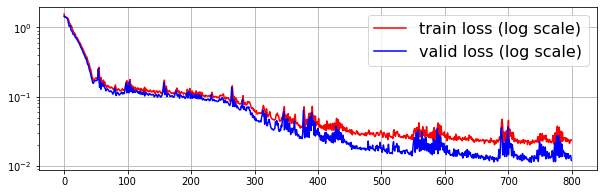

In [10]:
fig_trainloss = plt.figure(figsize=(10, 3))
plt.plot(train_losses, color='r', label='train loss (log scale)')
plt.plot(val_losses, color='b', label='valid loss (log scale)')
plt.yscale("log")
plt.grid(True)
plt.legend(fontsize=16)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trainloss, "train&valid_loss")

In [11]:
# net_params = pickle.load(open(os.path.join(get_project_root(), "data", "trained_RNNs", "MemoryAntiNumber", "20230122-220547", "params_MemoryAntiNumber_0.02719.pkl"), "rb+"))

In [12]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=net_params["bias_rec"],
                      y_init=net_params["y_init"])

In [13]:
analyzer = PerformanceAnalyzer(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)

In [14]:
print(f"MSE validation: {np.round(score, 5)}")
if not (datasaver is None): datasaver.save_data(config_dict, "config.json")
if not (datasaver is None): datasaver.save_data(best_net_params, f"params_{taskname}_{np.round(score, 5)}.pkl")

MSE validation: 0.01703


Plotting random trials


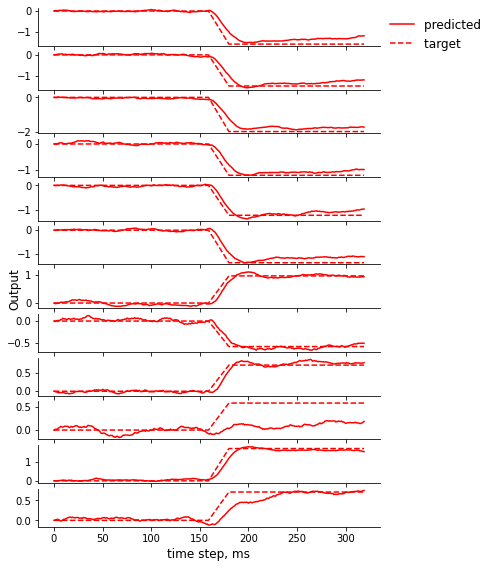

In [15]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trials, "random_trials")

In [16]:
dsa = DynamicSystemAnalyzer(RNN_valid)
params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":15,
          "patience":100,
          "stop_length":100,
          "mode":"approx"}
dsa.get_fixed_points(Input=np.array([0, 0]), **params)
dsa.get_fixed_points(Input=np.array([0, 1]), **params)

In [17]:
all_points = np.vstack([dsa.fp_data[str([0, 0])][type] for type in list(dsa.fp_data[str([0, 0])].keys())])
pca = PCA(n_components=1)
pca.fit(all_points)
P = np.zeros((RNN_valid.N, 2))
P[:, 0] = RNN_valid.W_out.flatten()
P[:, 1] = pca.components_.flatten()
# P = orthonormalize(P)

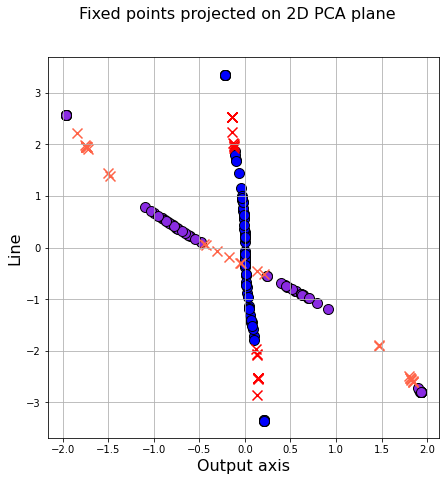

In [20]:
fig_fp = dsa.plot_fixed_points(projection='2D', P=P)
plt.xlabel("Output axis", fontsize=16)
plt.ylabel("Line", fontsize=16)
if disp:
    plt.show()